# \*\*\[CAM\]\*\*Original CAM

SEOYEON CHOI  
2023-09-15

https://seoyeonc.github.io/chch/cnn/feature%20extraction/big%20data%20analysis/2022/01/11/bd_9주차.html

https://seoyeonc.github.io/chch/cam/2022/01/10/bd-8주차_1.html

# import

In [1]:
import torch 
from fastai.vision.all import *
import cv2
import numpy as np
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torchvision.utils import save_image
import os

In [2]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [3]:
def label_func(f):
    if f[0].isupper():
        return 'cat' 
    else: 
        return 'dog' 

# path 지정

In [4]:
path=Path('original_pet') 
files=get_image_files(path)
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512)) 

In [5]:
path_r=Path('random_pet_one')   #랜덤박스넣은사진
files_r=get_image_files(path_r)
dls_r=ImageDataLoaders.from_name_func(path_r,files_r,label_func,item_tfms=Resize(512)) 

# Original 학습

In [ ]:
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)

/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/csy/anaconda3/envs/temp_csy/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

In [ ]:
net1=lrnr.model[0]
net2=lrnr.model[1] 

In [ ]:
net2 = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [ ]:
net=torch.nn.Sequential(net1,net2)

In [ ]:
lrnr2=Learner(dls,net,metrics=accuracy) 

In [ ]:
lrnr2.fine_tune(5) 

In [ ]:
interp = ClassificationInterpretation.from_learner(lrnr2)
interp.plot_confusion_matrix()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

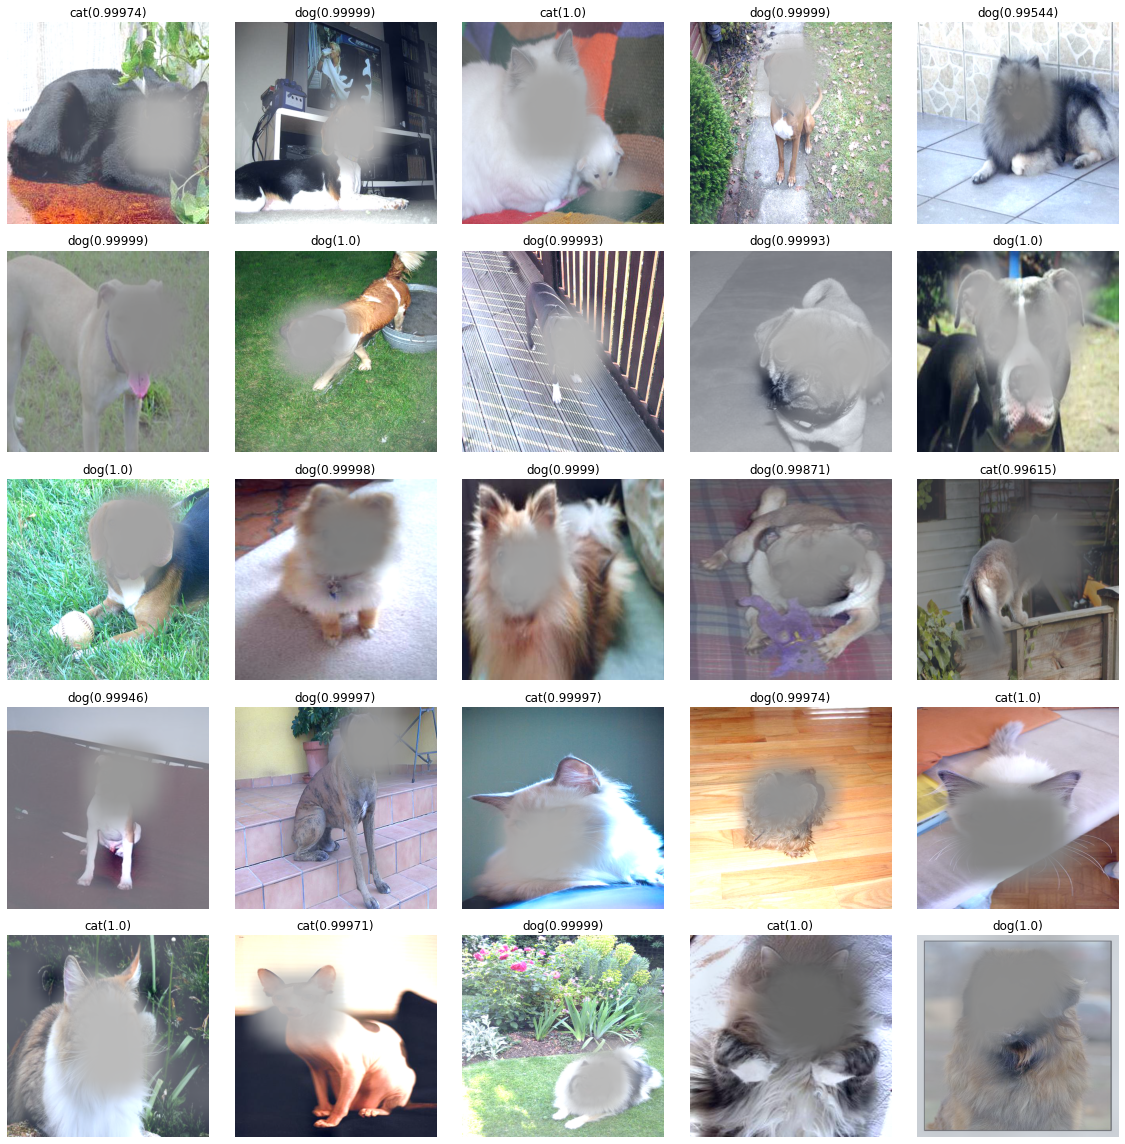

In [19]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls.test_dl([PILImage.create(get_image_files(path)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        catprob, dogprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b)) 
        if catprob>dogprob: 
            test=camimg[0]-torch.min(camimg[0])
            A1=torch.exp(-0.1*test)
            X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
            Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
            x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
            (x1*0.35).squeeze().show(ax=ax[i][j])
            ax[i][j].set_title("cat(%s)" % catprob.round(5))
        else: 
            test=camimg[1]-torch.min(camimg[1])
            A1=torch.exp(-0.1*test)
            X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
            Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
            x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu')*Y1)
            (x1*0.35).squeeze().show(ax=ax[i][j])
            ax[i][j].set_title("dog(%s)" % dogprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

# Random box 학습

In [ ]:
lrnr_r=cnn_learner(dls_r,resnet34,metrics=error_rate)
lrnr_r.fine_tune(1)

In [ ]:
net1_r=lrnr_r.model[0]
net2_r=lrnr_r.model[1] 

In [ ]:
net2_r = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1), 
    torch.nn.Flatten(),
    torch.nn.Linear(512,out_features=2,bias=False))

In [ ]:
net_r=torch.nn.Sequential(net1_r,net2_r)

In [ ]:
lrnr2_r=Learner(dls_r,net_r,metrics=accuracy) 

In [ ]:
lrnr2_r.fine_tune(5) 

In [ ]:
interp_r = ClassificationInterpretation.from_learner(lrnr2_r)
interp_r.plot_confusion_matrix()

In [ ]:
interp_r.print_classification_report()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

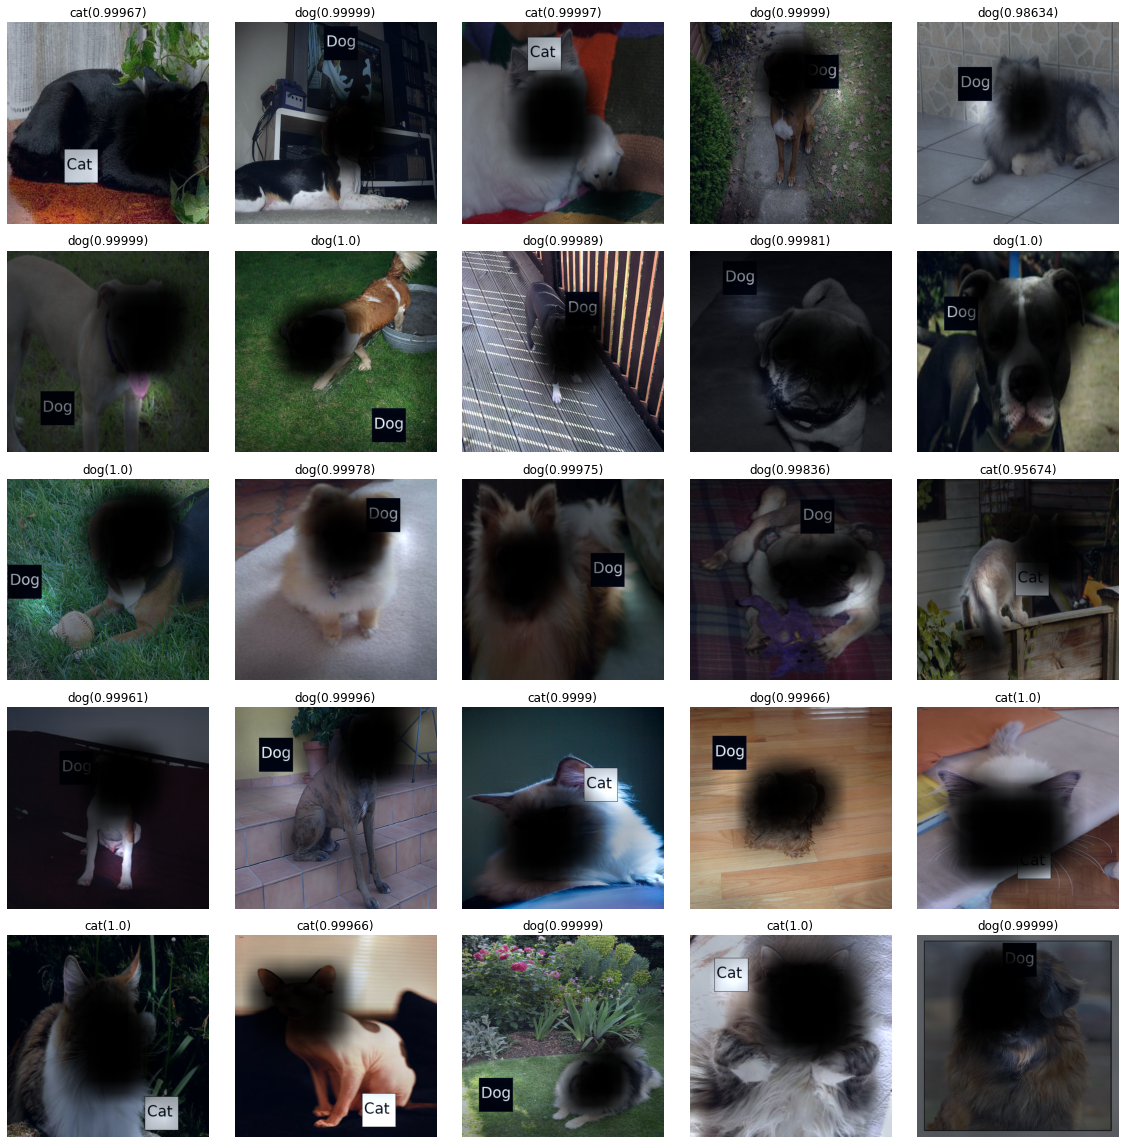

In [45]:
fig, ax = plt.subplots(5,5) 
k=0 
for i in range(5):
    for j in range(5): 
        x, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[k])]))
        camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())
        a,b = net(x).tolist()[0]
        catprob, dogprob = np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b))
        if catprob>dogprob: 
            test=camimg[0]-torch.min(camimg[0])
            A1=torch.exp(-0.1*test)
            X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
            Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
            x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu'))*Y1
            (x1*0.25).squeeze().show(ax=ax[i][j])
            ax[i][j].set_title("cat(%s)" % catprob.round(5))
        else: 
            test=camimg[1]-torch.min(camimg[1])
            A1=torch.exp(-0.1*test)
            X1=np.array(A1.to("cpu").detach(),dtype=np.float32)
            Y1=torch.Tensor(cv2.resize(X1,(512,512),interpolation=cv2.INTER_LINEAR))
            x1=x.squeeze().to('cpu')*Y1-torch.min(x.squeeze().to('cpu'))*Y1
            (x1*0.25).squeeze().show(ax=ax[i][j])
            ax[i][j].set_title("dog(%s)" % dogprob.round(5))
        k=k+1 
fig.set_figwidth(16)            
fig.set_figheight(16)
fig.tight_layout()

# Original 결과

## CAT

In [67]:
x, = first(dls.test_dl([PILImage.create(get_image_files(path)[2])]))

In [68]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

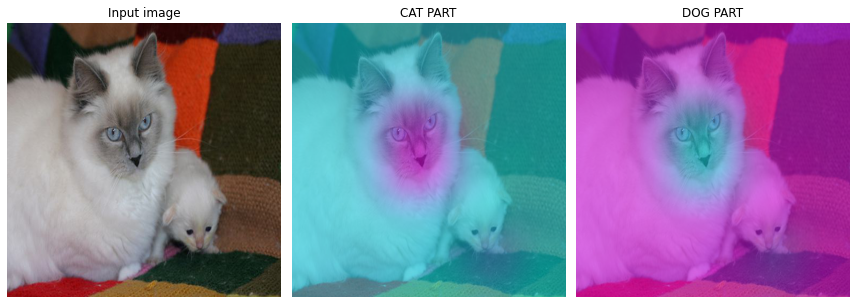

In [69]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow((camimg[0]).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("CAT PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow((camimg[1]).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

-   판단 근거가 강할 수록 파란색 -\> 보라색

In [70]:
a,b = net(x).tolist()[0]

In [71]:
np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b))

## DOG

In [73]:
x, = first(dls.test_dl([PILImage.create(get_image_files(path)[12])]))

In [74]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

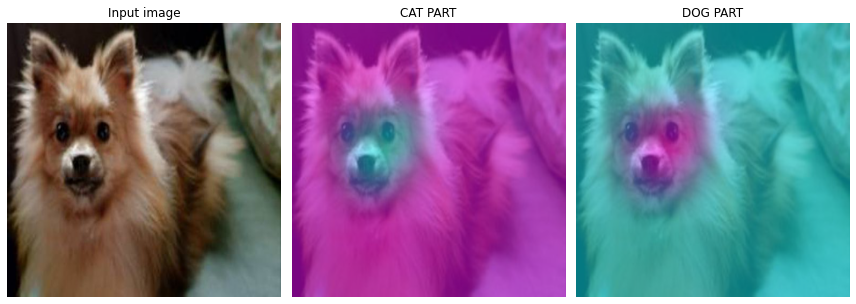

In [75]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
dls.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow((camimg[0]).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("CAT PART")
#
dls.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow((camimg[1]).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

-   판단 근거가 강할 수록 파란색 -\> 보라색

In [76]:
a,b = net(x).tolist()[0]

In [77]:
np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b))

# Random box 결과

## CAT

In [56]:
x, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[2])]))

In [57]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

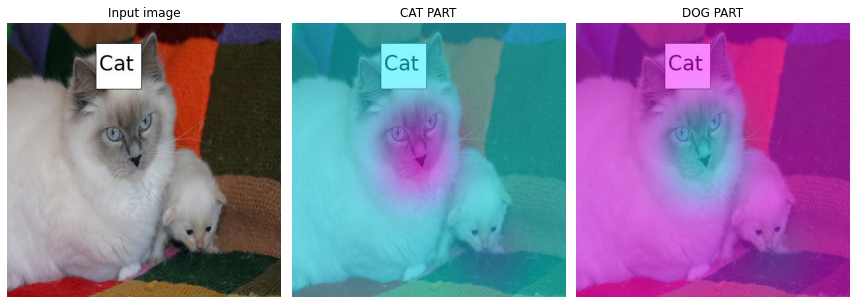

In [58]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls_r.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
dls_r.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow((camimg[0]).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("CAT PART")
#
dls_r.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow((camimg[1]).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

-   판단 근거가 강할 수록 파란색 -\> 보라색

In [59]:
a,b = net(x).tolist()[0]

In [60]:
np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b))

## DOG

In [61]:
x, = first(dls_r.test_dl([PILImage.create(get_image_files(path_r)[12])]))

In [62]:
camimg = torch.einsum('ij,jkl -> ikl', net2[2].weight, net1(x).squeeze())

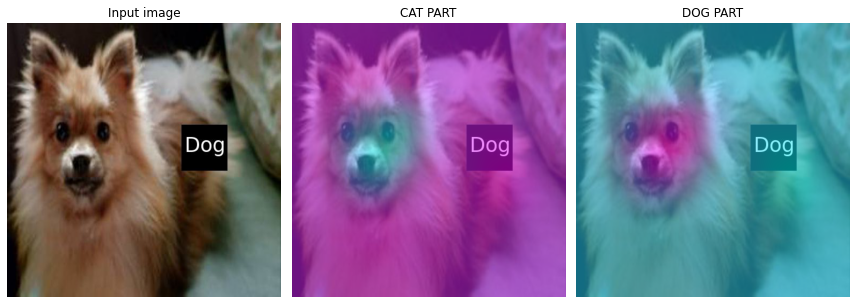

In [63]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3) 
# 
dls_r.train.decode((x,))[0].squeeze().show(ax=ax1)
ax1.set_title("Input image")
# 
dls_r.train.decode((x,))[0].squeeze().show(ax=ax2)
ax2.imshow((camimg[0]).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax2.set_title("CAT PART")
#
dls_r.train.decode((x,))[0].squeeze().show(ax=ax3)
ax3.imshow((camimg[1]).to("cpu").detach(),alpha=0.5,extent=(0,511,511,0),interpolation='bilinear',cmap='cool')
ax3.set_title("DOG PART")
#
fig.set_figwidth(12)            
fig.set_figheight(12)
fig.tight_layout()

-   판단 근거가 강할 수록 파란색 -\> 보라색

In [64]:
a,b = net(x).tolist()[0]

In [65]:
np.exp(a)/ (np.exp(a)+np.exp(b)) ,  np.exp(b)/ (np.exp(a)+np.exp(b))